In [1]:
import pickle
import tensorflow as tf
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn import metrics
from sklearn.utils import resample
import os
import traceback
from collections import deque
from __future__ import division

import seaborn as sns
from tensorflow.contrib.cudnn_rnn import CudnnCompatibleGRUCell as GRUCell
from tensorflow.contrib.rnn import DropoutWrapper as DoW
sns.set()

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [2]:
path = '/scratch/users/rmth/tf_logs/c-shhs_cluster_revised-shallow_cv/'
#path = '/scratch/users/rmth/tf_logs/c-shhs-multimodal_cluster_revised-shallow_cv/'
#path = '/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/'
#path = '/scratch/users/rmth/tf_logs_jun20/r-c-shhs_cluster_revised-shallow-noise_cv/'
fold_folders = [ e for e in os.listdir(path) if os.path.isdir(os.path.join(path, e)) ]
print(fold_folders)

['cv3', 'cv4', 'cv6', 'cv2', 'cv5', 'cv7', 'cv8', 'cv9', 'cv1']


In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p,:]

def gen_data(exp, con, batch_size, max_length, n_features, noise = False):
    n = batch_size // 2
    x = np.zeros(shape = (batch_size, max_length, n_features))
    y = np.zeros(shape = (batch_size, 2))
    shuffle(exp)
    shuffle(con)
    for i in range(n):
        e = exp[i]
        #print('e.shape1: {}'.format(e.shape[0]))
        c = con[i]
        #print('c.shape1: {}'.format(c.shape[0]))
        y[i,0] = 1
        if noise:
            x[i+n, 0:e.shape[0], 0:n_features] = e+np.random.normal(0, scale=0.5,size=e.shape)
            x[i, 0:c.shape[0], 0:n_features] = c+np.random.normal(0, scale=0.5, size=c.shape)
        else:
            x[i+n, 0:e.shape[0], 0:n_features] = e
            x[i, 0:c.shape[0], 0:n_features] = c
        y[i+n,1] = 1
    return unison_shuffled_copies(x,y)

In [4]:
def gen_data(exp, con, batch_size, max_length, n_features, noise = False):
    epoch_counter = 0
    while True:
        epoch_counter += 1
        if epoch_counter % 10 == 0:
            print('Epoch: {}'.format(epoch_counter))
        shuffle(exp)
        shuffle(con)
        n_batches = len(exp+con)// batch_size
        for j in range(n_batches):
            x = np.zeros(shape = (batch_size, max_length, n_features))
            y = np.zeros(shape = (batch_size, 2))
            n = batch_size // 2
            for i in range(n):
                e = exp[j*n+i]
                #print('e.shape1: {}'.format(e.shape[0]))
                c = con[j*n+i]
                #print('c.shape1: {}'.format(c.shape[0]))
                y[i,0] = 1
                if noise:
                    x[i+n, 0:e.shape[0], 0:n_features] = e+np.random.normal(0, scale=0.5,size=e.shape)
                    x[i, 0:c.shape[0], 0:n_features] = c+np.random.normal(0, scale=0.5, size=c.shape)
                else:
                    x[i+n, 0:e.shape[0], 0:n_features] = e
                    x[i, 0:c.shape[0], 0:n_features] = c
                y[i+n,1] = 1
            yield unison_shuffled_copies(x,y)

In [5]:
hidden_size = None # 1024
hidden_sizes = [128,128]
n_dense = 256
batch_size_train = 8
regularization = 1e-1
dense_regularization = 1e-1
rnn_dropout_prob = 0.3
lr = 1e-4
display_step = 20
buffer_length = 3
final_dropout = 0.05
max_step = 300#2000# 1000
tol = 1e-1 
patience = 2

##Test accuracy: 0.57 (CI: [0.505-0.63] +/- 0.0922)
##Test sens: 0.575 (CI: [0.491-0.659] +/- 0.12)
##Test spec: 0.562 (CI: [0.448-0.676] +/- 0.164)

##Test accuracy: 0.541 (CI: [0.513-0.576] +/- 0.0466)
##Test sens: 0.471 (CI: [0.282-0.671] +/- 0.282)
##Test spec: 0.61 (CI: [0.451-0.773] +/- 0.224)

In [6]:
hidden_size = None # 1024
hidden_sizes = [512]
n_dense = 1024
batch_size_train = 8
regularization = 1e-1
dense_regularization = 1e-1
rnn_dropout_prob = 0.4
lr = 1e-5
display_step = 20
buffer_length = 3
final_dropout = 0.05
max_step = 3000 #5000# 1000
tol = 10 #1e-1
patience = 2

##Test accuracy: 0.583 (CI: [0.493-0.675] +/- 0.13)
##Test sens: 0.659 (CI: [0.535-0.764] +/- 0.161)
##Test spec: 0.508 (CI: [0.306-0.704] +/- 0.283)


#Test accuracy: 0.575 (CI: [0.513-0.635] +/- 0.0854)
#Test sens: 0.316 (CI: [0.182-0.472] +/- 0.205)
#Test spec: 0.833 (CI: [0.759-0.91] +/- 0.11)

In [51]:
hidden_size = 16 #None # 1024
hidden_sizes = None #[1024]
n_dense = 1096
batch_size_train = 8
regularization = 1e-1
dense_regularization = 1e-1
rnn_dropout_prob = 0.2
lr = 1e-4
decay_rate = 0.99
display_step = 14
buffer_length = 3
final_dropout = 0.05
max_step = 3000 #5000# 1000
tol = 5 #1e-1
patience = 2




In [52]:
#Test accuracy: 0.588 (CI: [0.526-0.655] +/- 0.0905)
#Test sens: 0.47 (CI: [0.356-0.593] +/- 0.167)
#Test spec: 0.706 (CI: [0.526-0.867] +/- 0.244)


In [53]:
rocfigs, rocs = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
f1figs, f1s = plt.subplots(ncols=3, nrows=3, figsize=(20,20))
senses_aggr = []
speces_aggr = []
accs_aggr = []
cv_id_outcomes = {}

senses_aggr_easy = []
speces_aggr_easy = []
accs_aggr_easy = []

y_test_aggregated = [] #append(y_test)
softmax_test_aggregated = [] #append(softmax_test)
for fold_counter, fold in enumerate(fold_folders):
    #if fold != 'cv7':
    #    continue
    try:
        print('Training {} ({} of {})'.format(fold, fold_counter+1, len(fold_folders)))
        fold_number = int(fold[2])
        with open(path + fold + '/eval/' + 'features.pkl', 'rb') as f:
            train_group, train_feat, val_group, val_feat, test_group, test_feat, matched_feat, matched_group = pickle.load(f)#, encoding='latin1')
            
        matched_ids = [e for e in matched_group.keys()]
        
        train_label_exp = []
        train_feat_exp = []
        train_label_con = []
        train_feat_con = []
        for k, v in train_group.items():
            if v:
                train_label_exp.append(v)
                train_feat_exp.append(train_feat[k])
            else:
                train_label_con.append(v)
                train_feat_con.append(train_feat[k])
        
        val_label = []
        val_ft = []
        val_ids = []
        for k,v in val_group.items():
            if v:
                val_label.append(v)
                val_ft.append(val_feat[k])
                val_ids.append(k)
        n_exp_val = len(val_label)

        test_label = []
        test_ft = []
        test_ids = []
        test_con_easy_label = []
        test_ft_con_easy = []
        test_ids_con_easy = []
        for k,v in test_group.items():
            if v:
                test_label.append(v)
                test_ft.append(test_feat[k])
                test_ids.append(k)
            else:
                test_con_easy_label.append(v)
                test_ft_con_easy.append(test_feat[k])
                test_ids_con_easy.append(k)
        n_exp_test = len(test_label)

        shuffle(matched_ids)
        
        matched_id_val = []
        matched_label_val = []
        matched_feat_val = []
        for k, v in matched_group.items():
            if k in matched_ids[:n_exp_val]:
                matched_label_val.append(v)
                matched_feat_val.append(matched_feat[k])
                matched_id_val.append(k)

        matched_id_test = []
        matched_label_test = []
        matched_feat_test = []
        for k, v in matched_group.items():
            if k in matched_ids[n_exp_val:n_exp_val+n_exp_test]: 
                matched_label_test.append(v)
                matched_feat_test.append(matched_feat[k])
                matched_id_test.append(k)

        matched_id_train = []
        matched_label_train = []
        matched_feat_train = []
        for k, v in matched_group.items():
            if k in matched_ids[n_exp_val+n_exp_test:]:
                matched_label_train.append(v)
                matched_feat_train.append(matched_feat[k])
                matched_id_train.append(k)
                
        _,n_features = train_feat_exp[0].shape
        max_length = np.max([len(e) for e in train_feat_exp + train_feat_con + val_ft + matched_feat_train + matched_feat_test])
        
        x_test_easy_ids = test_ids_con_easy[:n_exp_test] + test_ids

        x_test_easy = np.zeros(shape=(n_exp_test*2, max_length, n_features))
        y_test_easy = np.zeros(shape=(n_exp_test*2, 2))
        y_test_easy[0:n_exp_test,0] = 1
        y_test_easy[n_exp_test:,1] = 1
        for i,e in enumerate(test_ft_con_easy[:n_exp_test]+test_ft):
            x_test_easy[i, 0:len(e), :] = e
            
        x_test_ids = matched_id_test + test_ids
        x_test = np.zeros(shape=(n_exp_test*2, max_length, n_features))
        y_test = np.zeros(shape=(n_exp_test*2, 2))
        y_test[0:n_exp_test,0] = 1
        y_test[n_exp_test:,1] = 1    
        for i,e in enumerate(matched_feat_test+test_ft):
            x_test[i, 0:len(e), :] = e
        
        x_val_ids = matched_id_val + val_ids
        x_val = np.zeros(shape=(n_exp_val*2, max_length, n_features))
        y_val = np.zeros(shape=(n_exp_val*2, 2))
        y_val[0:n_exp_val,0] = 1
        y_val[n_exp_val:,1] = 1
        for i,e in enumerate(matched_feat_val+val_ft):
            x_val[i, 0:len(e), :] = e
            
        
        tf.reset_default_graph()
        x = tf.placeholder(shape=(None, max_length, n_features), dtype=tf.float32)
        y = tf.placeholder(shape=(None, 2), dtype=tf.float32)
        prob = tf.placeholder_with_default(1.0, shape=())
        final_prob = tf.placeholder_with_default(1.0, shape=())
        batch_size = tf.shape(x)[0]
        '''
        cnn_in = tf.expand_dims(x, 3)
        out1 = tf.layers.conv2d(
                        inputs = cnn_in,
                        filters = 16,
                        strides = (1,50),
                        kernel_size = (3,100))
        out2 = tf.layers.conv2d(
                        inputs = out1,
                        filters = 16,
                        strides = (1,50),
                        kernel_size = (3,100))
        
        out3 = tf.layers.max_pooling2d(
                                        inputs = out2,
                                        pool_size = (2,10),
                                        strides=(1,15)
                                    )


        print(cnn_in.shape)
        print(out1.shape)
        print(out2.shape)
        print(out3.shape)
        logit_input = tf.contrib.layers.flatten(out3)
        '''
        
        #print('x: {}'.format(x.shape))
        rnn_input = tf.transpose(x, [1, 0, 2])
        #print('rnn_input: {}'.format(rnn_input.shape))
        cell = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers = 1,
                                        num_units = hidden_size,
                                        direction='unidirectional'
                                    )  #
                                       
        outputs,_ = cell(inputs=rnn_input)
        #print('outputs: {}'.format(outputs.shape))
        tmp = tf.transpose(outputs, [1, 0, 2])
        #print('tmp: {}'.format(tmp.shape))
        logit_input = tf.reshape(tmp, [batch_size, 24*1*hidden_size])
        #print('logit_input: {}'.format(logit_input.shape))
        
        dense = tf.layers.dense(inputs=logit_input,
                                 units=n_dense,
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=dense_regularization),
                                 activation=tf.nn.relu
                                 )
        do = tf.nn.dropout(dense,
                        keep_prob=final_prob)

        logit = tf.layers.dense(inputs=do,
                                 units=2)

        tv = tf.trainable_variables()
        regularization_cost = regularization * tf.reduce_sum([tf.nn.l2_loss(v) for v in tv])

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y)) + regularization_cost

        
        step = tf.Variable(0, trainable=False)
        rate = tf.train.exponential_decay(lr, step, 1, decay_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=rate).minimize(cost, global_step=step)
        
        #optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
        pred = tf.argmax(logit,1)
        correct_pred = tf.equal(pred, tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        softmax = tf.nn.softmax(logit)
        init = tf.global_variables_initializer()
        generator = gen_data(train_feat_exp, matched_feat_train, batch_size_train, max_length, n_features)
        #generator_easy = gen_data(train_feat_exp, train_feat_con, batch_size_train, max_length, n_features)
            
        with tf.Session() as sess:
            sess.run(init)
            step = 0
            patience = 0
            while True:
                step += 1
                batch_x, batch_y = next(generator)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, prob: rnn_dropout_prob, final_prob: final_dropout})
                if step % display_step == 0 or step == 1:
                    acc, loss, decayed_lr = sess.run([accuracy, cost, rate], feed_dict={x: batch_x, y: batch_y})
                    #print('{:.8f}'.format(decayed_lr))
                    acc_val, loss_val = sess.run([accuracy, cost], feed_dict = {x: x_val, y: y_val, prob: 1.0, final_prob: 1.0})
                    if step == 1:
                        smoothed_val_losses = deque(np.ones(buffer_length)*loss_val)
                        diff = 0
                    else:
                        mean1 = np.mean(smoothed_val_losses)
                        smoothed_val_losses.popleft()
                        smoothed_val_losses.append(loss_val)
                        mean2 = np.mean(smoothed_val_losses)
                        diff = mean1-mean2
                        #print(diff)
                        #print(smoothed_val_losses)
                        #print(patience)
                    if step > 2*buffer_length*display_step:
                        if diff < tol:
                            patience -= 1
                        elif patience < 1:
                            patience += 1
                        if patience < 0 or step > max_step:
                            break
                    print('step: {}, train loss: {:.2f}, accuracy: {:.2f}, val loss: {:.2f}, val accuracy: {:.2f}, diff: {:.4f}'.format(step, loss, acc, loss_val, acc_val,diff))

            acc_val, softmax_val = sess.run([accuracy, softmax], feed_dict = {x: x_val, y: y_val, prob: 1.0, final_prob: 1.0})
            acc_test_easy, softmax_test_easy = sess.run([accuracy, softmax], feed_dict={x: x_test_easy, y: y_test_easy, prob: 1.0, final_prob: 1.0})
            acc_test, softmax_test = sess.run([accuracy, softmax], feed_dict = {x: x_test, y: y_test, prob: 1.0, final_prob: 1.0})

        y_test_aggregated.append(y_test)
        softmax_test_aggregated.append(softmax_test)
            
        fpr_val, tpr_val, thress_val = roc_curve(np.argmax(y_val,axis=1), softmax_val[:,1])
        fpr_test_easy, tpr_test_easy, thress_test_easy = roc_curve(np.argmax(y_test_easy,axis=1), softmax_test_easy[:,1])
        fpr_test, tpr_test, thress_test = roc_curve(np.argmax(y_test,axis=1), softmax_test[:,1])

        
        auc_val = auc(fpr_val, tpr_val)
        auc_test = auc(fpr_test, tpr_test)
        auc_test_easy = auc(fpr_test_easy, tpr_test_easy)

        print('Final: AUC={}, acc.={}'.format(auc_test, acc_test))
        
        f1s_original = []
        for t in thress_val:
            f1s_original.append(f1_score(y_true=np.argmax(y_val,axis=1), y_pred=np.asarray(softmax_val[:,1] > t, dtype=np.float32)))

        n_bootstraps = 300
        thress_val = np.arange(0,1,0.05)
        f1s_bootstraps = np.zeros((len(thress_val), n_bootstraps))
        accs_bootstraps = np.zeros((len(thress_val), n_bootstraps))
        true_val = np.argmax(y_val,axis=1)
        est_val = softmax_val[:,1]
        pairs = np.zeros((len(true_val), 2))
        pairs[:,0] = true_val
        pairs[:,1] = est_val
        for j in range(n_bootstraps):
            #if j % 100 == 0:
            #    print(j/n_bootstraps*100)
            pairs_boot = resample(pairs, n_samples = 20, replace=True)
            true_val_boot = pairs_boot[:,0]
            est_val_boot = pairs_boot[:,1]
            for i, t in enumerate(thress_val):
                tn, fp, fn, tp = metrics.confusion_matrix(true_val_boot, np.asarray(est_val_boot > t, dtype=np.float32)).ravel()
                tpr = tp/(tp+fn)
                fpr = fp/(tn+fp)
                speci = 1-fpr
                f1s_bootstraps[i, j] = 2 * (tpr * speci) / (tpr + speci + np.spacing(0))
                #f1s_bootstraps[i, j] = f1_score(y_true=true_val_boot, y_pred=np.asarray(est_val_boot > t, dtype=np.float32))
                accs_bootstraps[i, j] = accuracy_score(y_true=true_val_boot, y_pred=np.asarray(est_val_boot > t, dtype=np.float32))

        f1s_m = np.median(f1s_bootstraps, axis=1)
        accs = np.mean(accs_bootstraps, axis=1)

        f1s_l = np.percentile(f1s_bootstraps, q=5, axis=1)
        f1s_u = np.percentile(f1s_bootstraps, q=95, axis=1)
        index = f1s_m/(f1s_u - f1s_l + np.spacing(0))

        best_t_idx = np.nanargmax(index)
        #best_t_idx = np.nanargmax(f1s_m)
        best_t = thress_val[best_t_idx]

        test_accuracy_easy = accuracy_score(y_true=np.argmax(y_test_easy, axis=1),
                                       y_pred=np.asarray(softmax_test_easy[:, 1] > best_t, dtype=np.float32))
        tn, fp, fn, tp = metrics.confusion_matrix(np.argmax(y_test_easy, axis=1), softmax_test_easy[:, 1] > best_t).ravel()
        test_sensitivity_easy = tp / (tp + fn)
        test_specificity_easy = 1 - (fp / (tn + fp))

        accs_aggr_easy.append(test_accuracy_easy)
        senses_aggr_easy.append(test_sensitivity_easy)
        speces_aggr_easy.append(test_specificity_easy)

        test_accuracy = accuracy_score(y_true=np.argmax(y_test,axis=1), y_pred=np.asarray(softmax_test[:,1] > best_t, dtype=np.float32))
        tn, fp, fn, tp = metrics.confusion_matrix(np.argmax(y_test, axis=1), softmax_test[:, 1] > best_t).ravel()
        test_sensitivity = tp / (tp + fn)
        test_specificity = 1 - (fp / (tn+fp))

        id_binary_outcome = {}
        tmp_test_trues = np.argmax(y_test, axis=1)
        tmp_test_estimates = softmax_test[:, 1] > best_t
        outcomes = tmp_test_trues - 2*tmp_test_estimates
        for i,e in enumerate(outcomes):
            id_binary_outcome[x_test_ids[i]] = e
        
        cv_id_outcomes[fold] = id_binary_outcome
        accs_aggr.append(test_accuracy)
        senses_aggr.append(test_sensitivity)
        speces_aggr.append(test_specificity)

        lw = 2
        a = (fold_number - 1) // 3
        b = (fold_number - 1) % 3

        rocs[a,b].plot(fpr_test_easy, tpr_test_easy, '--', color='gray',
                   lw=lw,
                   label='Unmatched, AUC: {:.2f}'.format(auc_test_easy))
        rocs[a,b].plot(fpr_test, tpr_test, color='black',
                   lw=lw,
                   label='Matched, AUC: {:.2f}, acc.: {:.2f}, sens.: {:.2f}, spec.: {:.2f}'.format(auc_test,
                                                                                                test_accuracy,
                                                                                                test_sensitivity,
                                                                                                test_specificity, ))
        rocs[a,b].plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
        rocs[a,b].set_title('Cross-validation fold {}'.format(fold_number))
        rocs[a,b].legend(loc="lower right")
        rocs[a,b].set_xlim([0.0, 1.0])
        rocs[a,b].set_ylim([0.0, 1.0])
        rocs[a,b].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        rocs[a,b].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        if a == 2: 
            rocs[a,b].set_xlabel('False Positive Rate')
        else:
            rocs[a, b].set_xticklabels(['', '', '', '', '', ''])
        if b == 0:
            rocs[a,b].set_ylabel('True Positive Rate')
        else:
            rocs[a, b].set_yticklabels(['', '', '', '', '', ''])


        f1s[a,b].plot(thress_val, f1s_m, color='black')
        f1s[a, b].plot(thress_val[best_t_idx], f1s_m[best_t_idx], 'or')
        f1s[a, b].set_title('F1-scores (validation, bootstrapped): {}'.format(fold_number))
        f1s[a, b].set_ylim([0.0, 1.0])
        rocs[a,b].set_xlim([0.0, 1.0])
        f1s[a, b].set_xlabel('Threshold')
        f1s[a, b].set_ylabel('f1-score')

    except Exception as e:
        print('Something went wrong with: {}'.format(fold_number))
        print(e)
        print(traceback.format_exc())
print('Done.')


Training cv3 (1 of 9)
step: 1, train loss: 38.56, accuracy: 0.75, val loss: 38.56, val accuracy: 0.56, diff: 0.0000
step: 14, train loss: 35.67, accuracy: 0.62, val loss: 35.67, val accuracy: 0.56, diff: 0.9648
step: 28, train loss: 33.33, accuracy: 0.50, val loss: 33.31, val accuracy: 0.56, diff: 1.7511
step: 42, train loss: 31.44, accuracy: 0.88, val loss: 31.48, val accuracy: 0.56, diff: 2.3600
step: 56, train loss: 30.05, accuracy: 0.62, val loss: 30.04, val accuracy: 0.61, diff: 1.8768
step: 70, train loss: 28.88, accuracy: 0.62, val loss: 28.88, val accuracy: 0.61, diff: 1.4758
step: 84, train loss: 27.99, accuracy: 0.62, val loss: 27.94, val accuracy: 0.61, diff: 1.1820
Final: AUC=0.469135802469, acc.=0.5
Training cv4 (2 of 9)
step: 1, train loss: 38.70, accuracy: 0.50, val loss: 38.71, val accuracy: 0.50, diff: 0.0000
step: 14, train loss: 35.92, accuracy: 0.50, val loss: 35.93, val accuracy: 0.50, diff: 0.9254
step: 28, train loss: 33.63, accuracy: 0.50, val loss: 33.63, val a

In [30]:
with open(path + 'cv_id_outcomes', 'wb') as f:
    pickle.dump([cv_id_outcomes], f)

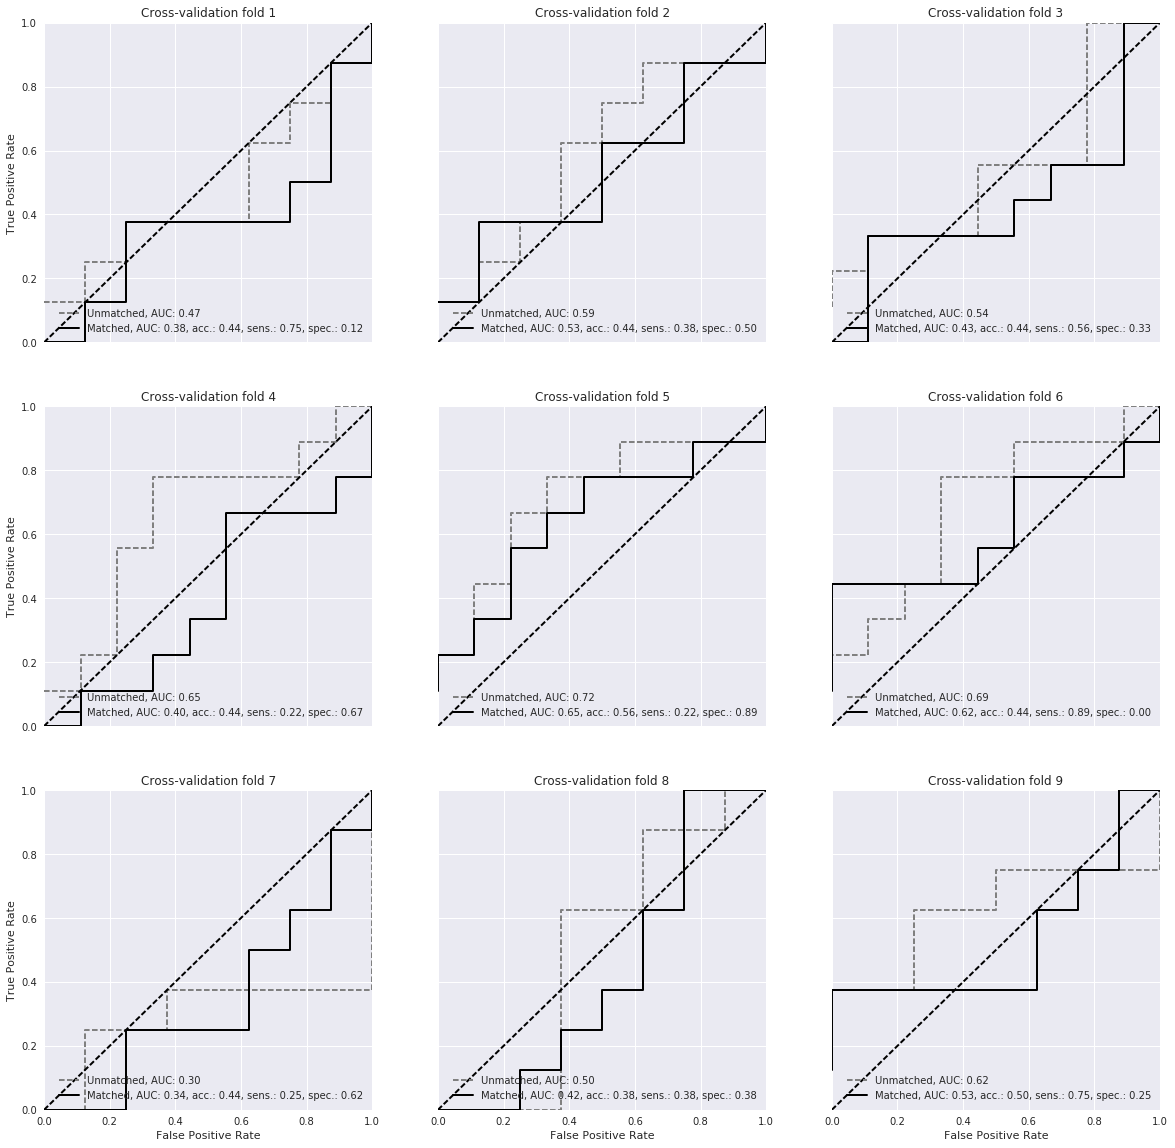

In [46]:
rocfigs

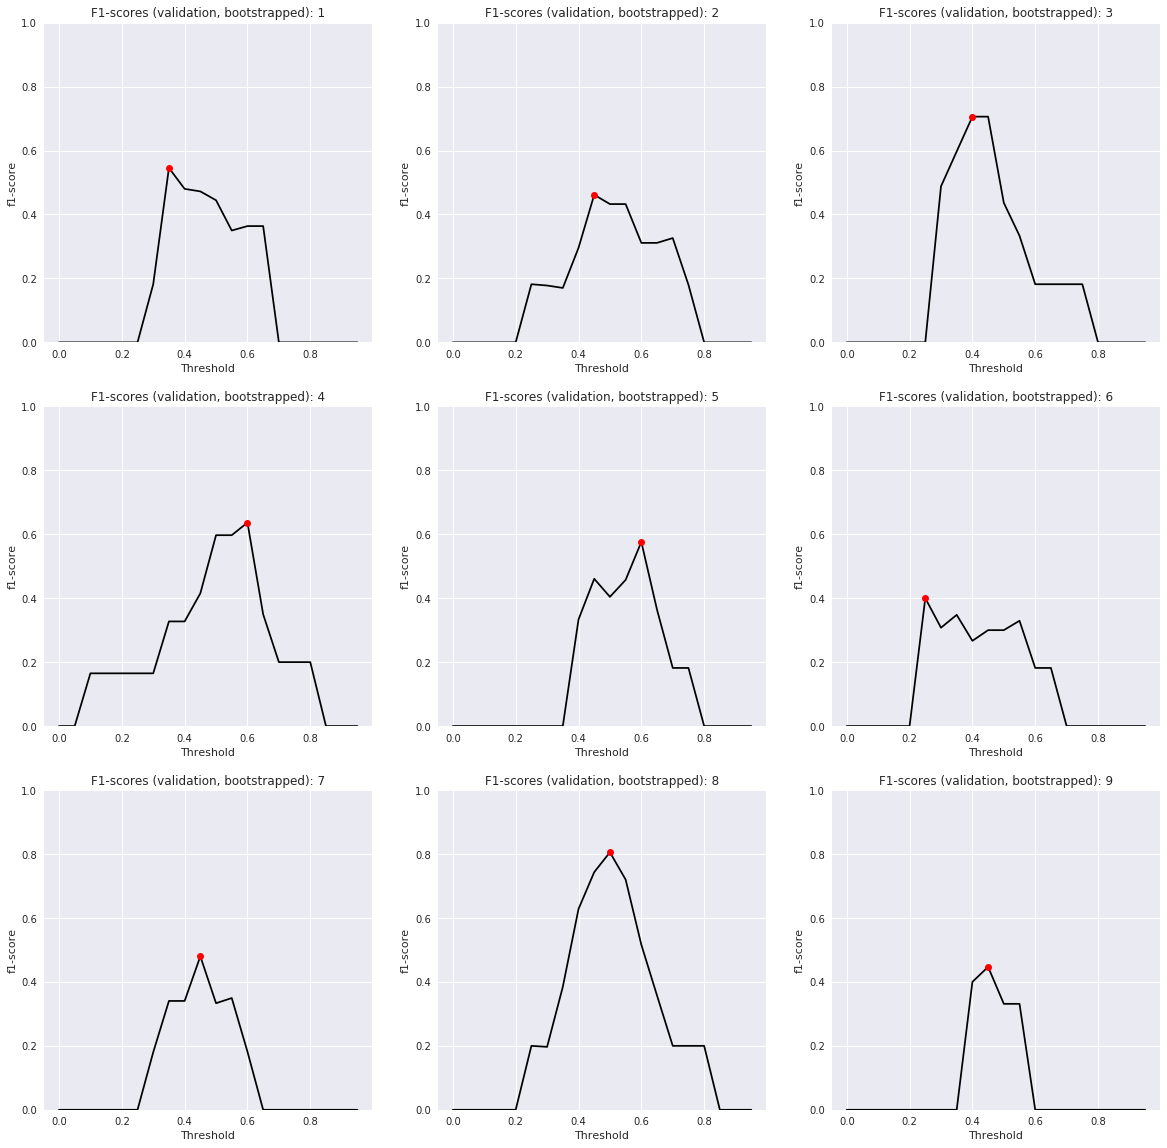

In [47]:
f1figs

In [45]:
accs_aggr

[0.44444444444444442,
 0.44444444444444442,
 0.44444444444444442,
 0.4375,
 0.55555555555555558,
 0.4375,
 0.375,
 0.5,
 0.4375]

In [39]:
# MATCHED!
n_bootstraps = 10000
test_accuracy_bootstraps_mean = np.ones(n_bootstraps)
test_accuracy_bootstraps_std = np.ones(n_bootstraps)

test_sens_bootstraps_mean = np.ones(n_bootstraps)
test_sens_bootstraps_std = np.ones(n_bootstraps)

test_spec_bootstraps_mean = np.ones(n_bootstraps)
test_spec_bootstraps_std = np.ones(n_bootstraps)
for j in range(n_bootstraps):
    sample = resample(accs_aggr)
    test_accuracy_bootstraps_mean[j] = np.mean(sample)
    test_accuracy_bootstraps_std[j] = np.std(sample)

    sample = resample(senses_aggr)
    test_sens_bootstraps_mean[j] = np.mean(sample)
    test_sens_bootstraps_std[j] = np.std(sample)

    sample = resample(speces_aggr)
    test_spec_bootstraps_mean[j] = np.mean(sample)
    test_spec_bootstraps_std[j] = np.std(sample)
    

acc_mean = np.mean(test_accuracy_bootstraps_mean)
acc_std = np.mean(test_accuracy_bootstraps_std)
acc_mean_l = np.percentile(test_accuracy_bootstraps_mean, 2.5)
acc_mean_u = np.percentile(test_accuracy_bootstraps_mean, 97.5)
print('Test accuracy: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(acc_mean, acc_mean_l, acc_mean_u, acc_std))

sens_mean = np.mean(test_sens_bootstraps_mean)
sens_std = np.mean(test_sens_bootstraps_std)
sens_mean_l = np.percentile(test_sens_bootstraps_mean, 2.5)
sens_mean_u = np.percentile(test_sens_bootstraps_mean, 97.5)
print('Test sens: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(sens_mean, sens_mean_l, sens_mean_u, sens_std))

spec_mean = np.mean(test_spec_bootstraps_mean)
spec_std = np.mean(test_spec_bootstraps_std)
spec_mean_l = np.percentile(test_spec_bootstraps_mean, 2.5)
spec_mean_u = np.percentile(test_spec_bootstraps_mean, 97.5)
print('Test spec: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(spec_mean, spec_mean_l, spec_mean_u, spec_std))


Test accuracy: 0.539 (CI: [0.492-0.572] +/- 0.0547)
Test sens: 0.497 (CI: [0.403-0.594] +/- 0.135)
Test spec: 0.58 (CI: [0.48-0.687] +/- 0.147)


In [40]:
# UNMATCHED!
n_bootstraps = 1000
test_accuracy_bootstraps_mean = np.ones(n_bootstraps)
test_accuracy_bootstraps_std = np.ones(n_bootstraps)

test_sens_bootstraps_mean = np.ones(n_bootstraps)
test_sens_bootstraps_std = np.ones(n_bootstraps)

test_spec_bootstraps_mean = np.ones(n_bootstraps)
test_spec_bootstraps_std = np.ones(n_bootstraps)
for j in range(n_bootstraps):
    sample = resample(accs_aggr_easy)
    test_accuracy_bootstraps_mean[j] = np.mean(sample)
    test_accuracy_bootstraps_std[j] = np.std(sample)

    sample = resample(senses_aggr_easy)
    test_sens_bootstraps_mean[j] = np.mean(sample)
    test_sens_bootstraps_std[j] = np.std(sample)

    sample = resample(speces_aggr_easy)
    test_spec_bootstraps_mean[j] = np.mean(sample)
    test_spec_bootstraps_std[j] = np.std(sample)
    

acc_mean = np.mean(test_accuracy_bootstraps_mean)
acc_std = np.mean(test_accuracy_bootstraps_std)
acc_mean_l = np.percentile(test_accuracy_bootstraps_mean, 2.5)
acc_mean_u = np.percentile(test_accuracy_bootstraps_mean, 97.5)
print('Test accuracy: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(acc_mean, acc_mean_l, acc_mean_u, acc_std))

sens_mean = np.mean(test_sens_bootstraps_mean)
sens_std = np.mean(test_sens_bootstraps_std)
sens_mean_l = np.percentile(test_sens_bootstraps_mean, 2.5)
sens_mean_u = np.percentile(test_sens_bootstraps_mean, 97.5)
print('Test sens: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(sens_mean, sens_mean_l, sens_mean_u, sens_std))

spec_mean = np.mean(test_spec_bootstraps_mean)
spec_std = np.mean(test_spec_bootstraps_std)
spec_mean_l = np.percentile(test_spec_bootstraps_mean, 2.5)
spec_mean_u = np.percentile(test_spec_bootstraps_mean, 97.5)
print('Test spec: {:.3} (CI: [{:.3}-{:.3}] +/- {:.3})'.format(spec_mean, spec_mean_l, spec_mean_u, spec_std))


Test accuracy: 0.524 (CI: [0.435-0.602] +/- 0.123)
Test sens: 0.497 (CI: [0.397-0.593] +/- 0.136)
Test spec: 0.549 (CI: [0.41-0.665] +/- 0.179)


0.499598684211 [0.421052631579-0.572368421053]


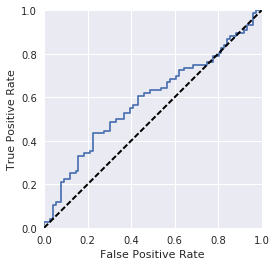

In [42]:
y_test = np.concatenate( y_test_aggregated, axis=0 )
softmax_test = np.concatenate( softmax_test_aggregated, axis=0 )
#print(softmax_test)
for t in np.arange(0,1,0.025):
    acc = accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.asarray(softmax_test[:, 1] > t, dtype=np.float32))
    #print('{} {}'.format(t,acc))
n = 100000
acc_list = []
for i in range(n_bootstraps):
    y_test_boot = resample(np.argmax(y_test, axis=1))
    y_pred_boot = resample(np.asarray(softmax_test[:, 1] > 0.4, dtype=np.float32))
    acc_loop = accuracy_score(y_true=y_test_boot, y_pred=y_pred_boot)
    acc_list.append(acc_loop)
fpr_test, tpr_test, thress_test = roc_curve(np.argmax(y_test,axis=1), softmax_test[:,1])
fpr_test, tpr_test, thress_test = roc_curve(np.argmax(y_test,axis=1), softmax_test[:,1])

mu = np.mean(acc_list)
li = np.percentile(acc_list, 2.5)
hi = np.percentile(acc_list, 97.5)
print('{} [{}-{}]'.format(np.mean(acc_list), li, hi))

#plt.figsize((10,5))
plt.plot(fpr_test, tpr_test)
plt.axis('scaled')
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.legend(loc="lower right")
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

In [ ]:
       
         #lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)
        #lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)

        #lstm_fw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_size)
        #lstm_bw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_size)
        
        #lstm_fw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        #lstm_bw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        
        #https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        
        '''
        gru_fw_layers = [DoW(GRUCell(hidden_size), output_keep_prob=prob) for hidden_size in hidden_sizes]
        multi_gru_fw_cell = tf.nn.rnn_cell.MultiRNNCell(gru_fw_layers)
        gru_bw_layers = [DoW(GRUCell(hidden_size), output_keep_prob=prob) for hidden_size in hidden_sizes]
        multi_gru_bw_cell = tf.nn.rnn_cell.MultiRNNCell(gru_bw_layers)
        outputs, states = tf.nn.bidirectional_dynamic_rnn(multi_gru_fw_cell, 
                                                          multi_gru_bw_cell, 
                                                          inputs=x, dtype=tf.float32)
        
        '''
        '''
        lstm_fw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(hidden_size)
        lstm_bw_cell = tf.contrib.cudnn_rnn.CudnnCompatibleGRUCell(hidden_size)

        lstm_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm_fw_cell, output_keep_prob=prob)
        lstm_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm_bw_cell, output_keep_prob=prob)

        #lstm_fw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)
        #lstm_bw_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(hidden_size, dropout_keep_prob = prob)

        outputs, states = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell, inputs=x, dtype=tf.float32)
        '''
        
        #output_rnn = tf.concat(states, axis=2)

        #output_rnn = tf.concat(outputs, axis=2)
        
        #print('output_rnn.shape: {}'.format(output_rnn.shape))

        #print('states.shape: {}'.format(states[0].shape))
        #states_flat = [tf.contrib.layers.flatten(e) for e in states]
        #print('states_flat.shape: {}'.format(states_flat[0].shape))
        #states_flat_concat = tf.concat(states_flat, axis=2)
        #print('states_flat.shape: {}'.format(states_flat.shape))
        
        #logit_input = tf.reshape(output_rnn, [batch_size, hidden_size*2*max_length])